In [1]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

## The libraries

In this section, I load the libraries I use.

A short explanation for libs, I assume that are not that well known.

[`pandas`](https://pandas.pydata.org/): This lib helps to easily analyze and manipulate data <br>
[`seaborn`](https://seaborn.pydata.org/): This lib is for advanced data visualization and is based on [`matplotlib`](https://matplotlib.org/) <br>
[`scikit-learn`](https://scikit-learn.org/stable/index.html): Simple and efficient tool for all kinds of (traditional) ML tasks.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

## Loading the data

First, it is needed to load the data. For this purpose I use the pandas library.

Overall, I experiment with scaling the pulloff-row, to see if this has an positive effect. It could actually help,
because most labels are very low scale (1e-8) and therefore, it is hard to get a good metric.

In [3]:
data_file1 = '../../../data/RoughContact/newPulloffJan28th.csv'
data_file2 = '../../../data/RoughContact/pulloff4AIlabelled.csv'

column_names = ['Hurst', 'L', 'LambdaR', 'LambdaS', 'surfaceEnergy', 'rho', 'pulloff']

dataset1 = pd.read_csv(data_file1, sep=';')
dataset2 = pd.read_csv(data_file2, sep=',')
data = pd.concat([dataset1, dataset2])

# Hurst doesn't have any meaning at the moment, so it can be dropped
data.pop('Hurst')

data

,L,lambdaR,lambdaS,surfaceEnergy,rho,pulloff
0,512,128,2,0.017343,0.015862,3.400000e-07
1,512,128,2,0.043357,0.029218,1.820000e-06
2,512,128,2,0.069371,0.039970,3.760000e-06
3,512,128,2,0.086714,0.058265,8.740000e-06
4,512,128,2,0.130071,0.076348,1.600000e-05
...,...,...,...,...,...,...
91,1024,128,2,0.951758,0.863281,2.372370e-02
92,1024,128,2,1.384375,1.108248,4.828920e-02
93,1024,128,2,1.990039,1.411591,8.272820e-02
94,1024,128,2,2.768750,1.759234,1.192725e-01


## Data Visualization

One of the most important things in machine learning is to know the data. One possible way is to use approbiate visualizations. 
With the knowledge we gain from visualizing the data, we can choose approbiate models.

So first I look at the correlations between the features. This is helpful, because we get a first idea about the relations in the data.
In this particular case, we see really strong correlations between the pulloff force, the surface energy and rho. The remaining features seem to 
be not that helpful. But that is natural, since the values of these columns don't vary very much. This is a first indication, that including the
features L, lambdaR and lambdaS won't help much.

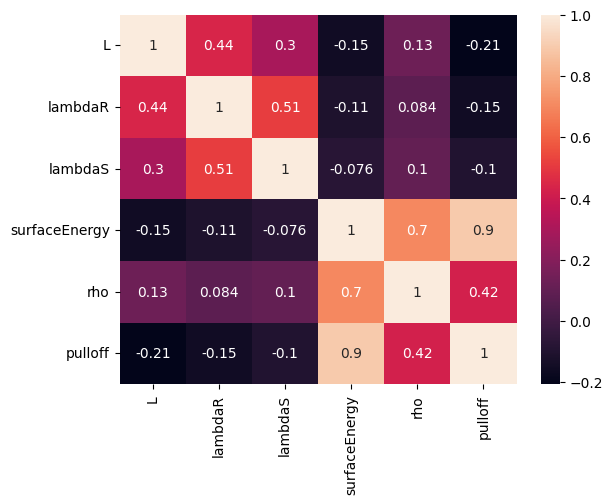

In [4]:
dataplot = sns.heatmap(data.corr(), cmap="rocket", annot=True)

plt.show()

### Pairplotting the relations

So now let's take a closer look at surfaceEnergy, rho and pulloff. What we can easily see is, that surfaceEnergy and rho have a really strong relationship. Perhaps this relationship can be exploited later on.

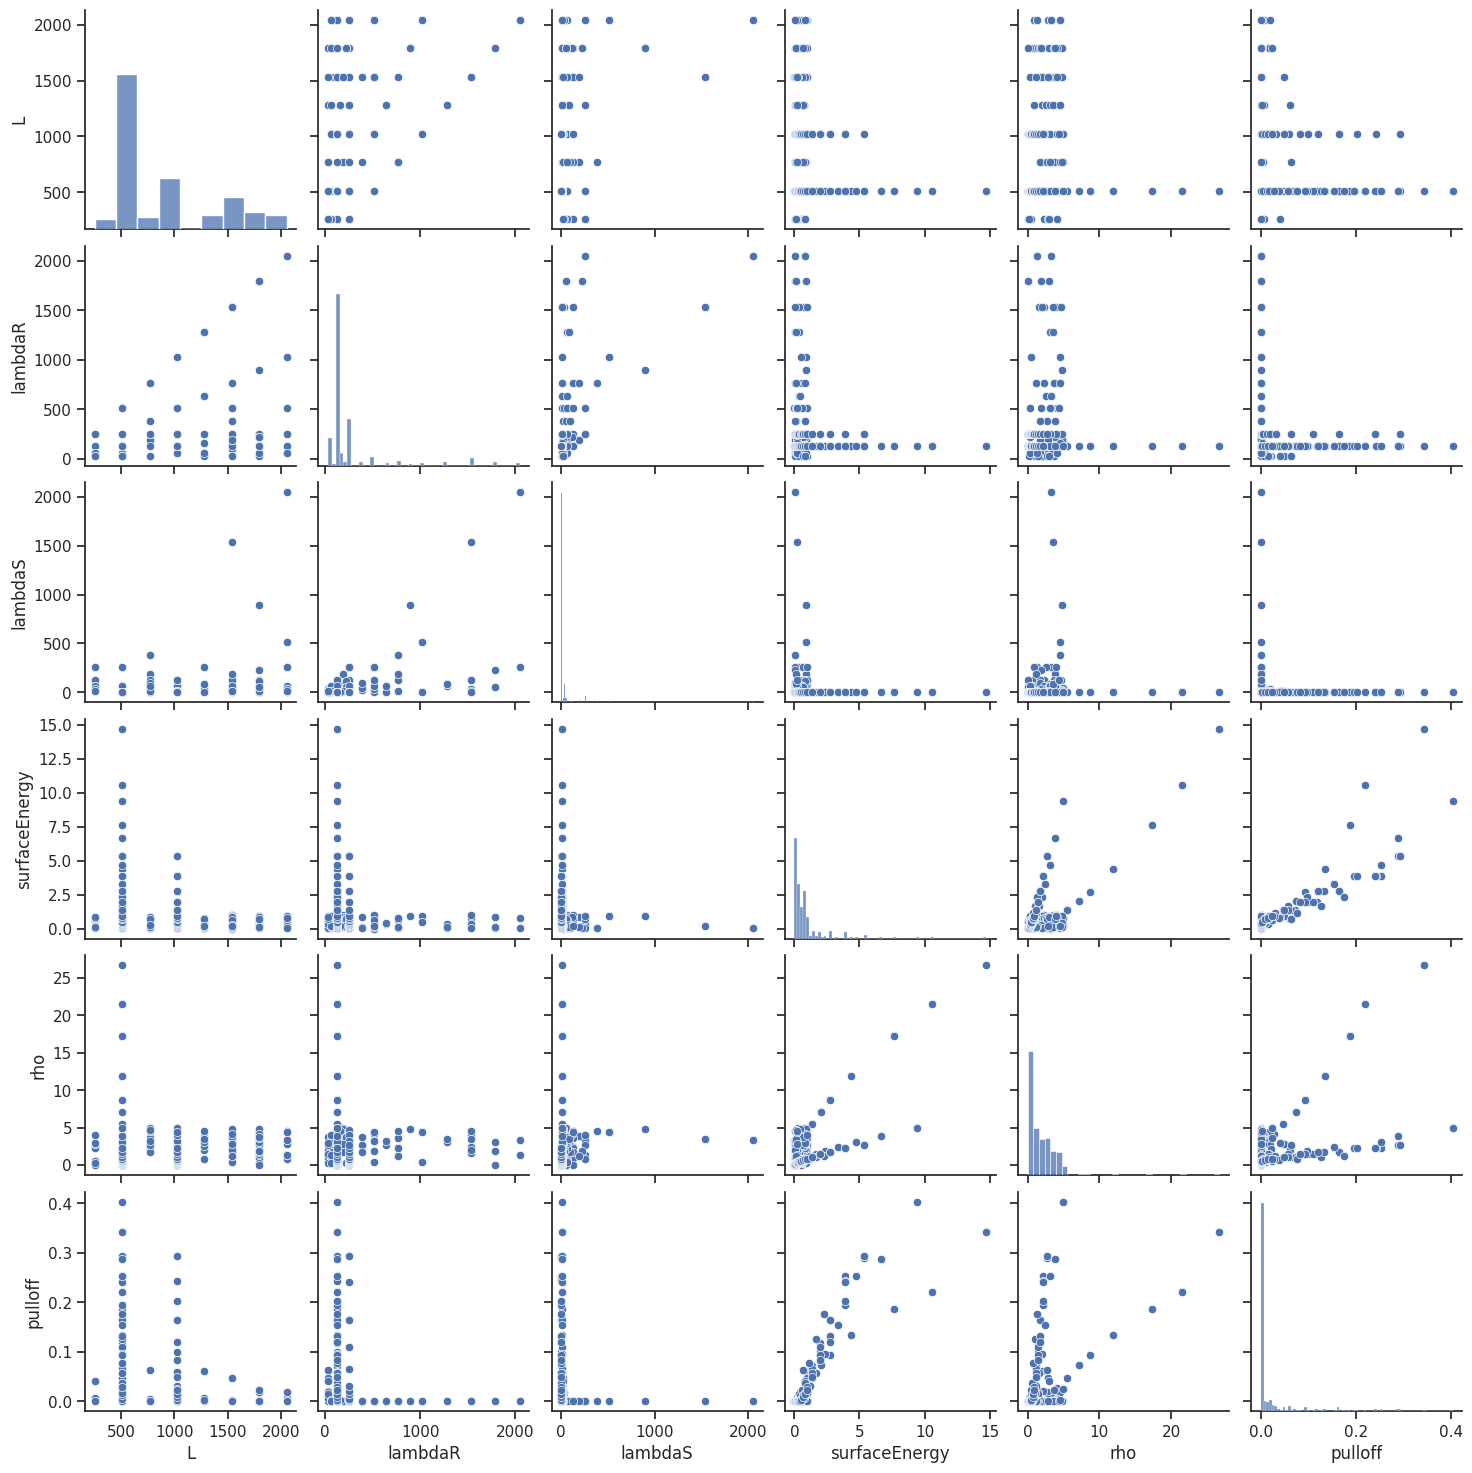

In [5]:
sns.set_theme(style="ticks")
sns.pairplot(data)

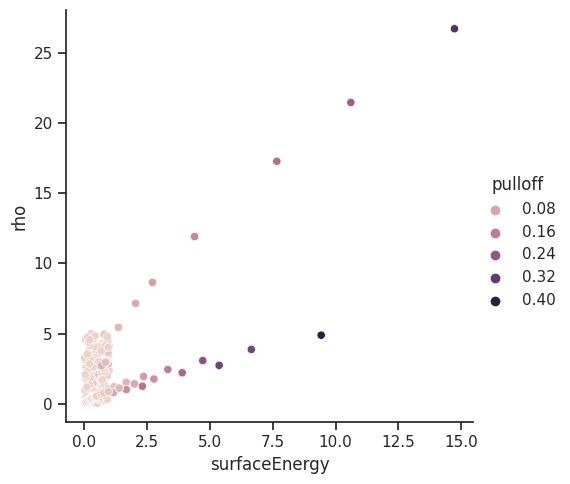

In [6]:
sns.set_theme(style="ticks")
sns.relplot(data[['surfaceEnergy', 'rho', 'pulloff']], x='surfaceEnergy', y='rho', hue='pulloff')

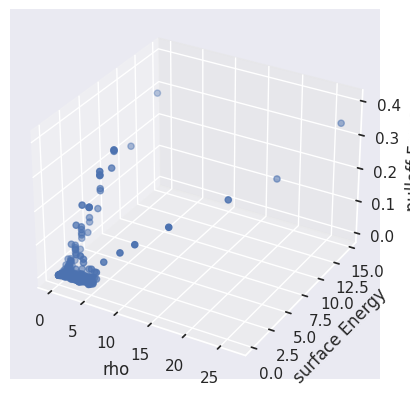

In [7]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = data['rho']
y = data['surfaceEnergy']
z = data['pulloff']

ax.set_xlabel("rho")
ax.set_ylabel("surface Energy")
ax.set_zlabel("pulloff Force")

ax.scatter(x, y, z)

plt.show()

## The models

First I will use traditional machine learning approaches. That especially means, that I won't use a deep learning approache at first.

In [8]:
dataset = data.copy()

train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

### The metrics

For better comparibility, all used models are evaluated with the same metrics. So here are a few explanations about the used metrics.

#### MSE

The mean squared error (MSE) is one of the most basic metrics one can apply, since all machine learning models
minimize explicitly or implicitly the MSE.
The definition of the MSE is as follows:

$$ MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 $$

This metric is due to its definition not that approbiate for this dataset, because most of the labels are very
small, e.g. $<1$, and therefore the MSE underestimates the error.

#### RSME

The root mean squared error (RSME) is as the name suggests the root of the MSE. So the definition is as
follows: 

$$ RSME = \sqrt{\frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 } $$

So inituively, the RSME can be thought of as a rescaled/centerd Euclidean Distance of the predicted outcomes,
compared with the the real observations. So this is a quite good measurement for this case and has a nice 
interpretability.

#### R2-score/Coefficient of determination

The definition of the R2-score is as follows:

$$ R^2 = 1 - \frac{RSS}{TSS} $$

where RSS stands for residual sum of squares and TSS stands for total sum of squares. The respective definitions 
are:

$$ RSS = \sum_{i=1}^n{(y_i - f(x_i))^2} \quad \text{and} \quad TSS = \sum_{i=1}^n{(y_i - \bar{y})^2} $$

With $\bar{y} = \frac{1}{n}\sum_{i=1}^n(y_i)$.

So this scores lies in the range [0,1]. Therefore it can be interpreted as a (procentual) measurement how well the
model predicts the outcome or how well the model describes the relation between the input and the ouput.

### Ordinary least squares regression

The first thing one can do in a regression task is to try out linear least squares. That sounds a bit too easy at first, but we can expect in that case even quite good results, because the two features, the surface energy and rho, are highly correlated with our desired target.

In [9]:
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

preds = regr.predict(test_dataset[['rho', 'surfaceEnergy']])

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean squared error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Coefficients: 
 [-0.00986349  0.04741214]
Mean squared error: 0.0003020244
Root Mean squared error: 0.0173788504
Mean squared error: 0.0150763426
Coefficient of determination: -10.03258


### Poynomial Regression

Here it is explored, what happens if we include polynomials of higher order. It showed to be best/stablest
to use polynomials of second order. In fact this model is one of the most capable ones I explored so far.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

pol_reg = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression(fit_intercept=False))
pol_reg.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

preds = pol_reg.predict(test_dataset[['rho', 'surfaceEnergy']])

# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Mean squared error: 0.0001925005
Root Mean squared error: 0.0138744561
Mean absolute error: 0.0121845622
Coefficient of determination: -6.03181


### Ensemble Methods

In general, ensemble methods use multiple models at once and use the prediction of all models in way or another. In
addition to that, most ensemble methods have mechanisms, which allow a reuse of the training data.

### AdaBoost regressor

An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits
additional copies of the regressor on the same dataset but where the weights of instances are adjusted according
to the error of the current prediction. As such, subsequent regressors focus more in difficult cases. 
(source: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html))

### RandomForest regressor

A random forest is a meta-estimator that fits a number of classifying decsion trees on various sub-samples of the
dataset and uses averaging to improve the predictive accuracy and control over-fitting.
(source: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html))

In [11]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState()

ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=20), n_estimators=500, learning_rate=1., random_state=rng
)

ada_regr.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

preds = ada_regr.predict(test_dataset[['rho', 'surfaceEnergy']])

# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Mean squared error: 0.0000826690
Root Mean squared error: 0.0090922511
Mean absolute error: 0.0066908416
Coefficient of determination: -2.01980


In [12]:
from sklearn.ensemble import RandomForestRegressor

randForestReg = RandomForestRegressor(n_estimators=500, criterion="absolute_error")
randForestReg.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

preds = randForestReg.predict(test_dataset[['rho', 'surfaceEnergy']])

# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Mean squared error: 0.0000649126
Root Mean squared error: 0.0080568333
Mean absolute error: 0.0055576175
Coefficient of determination: -1.37118


In [17]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=7)
knn_reg.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

preds = knn_reg.predict(test_dataset[['rho', 'surfaceEnergy']])

# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Mean squared error: 0.0000399006
Root Mean squared error: 0.0063166939
Mean absolute error: 0.0043169532
Coefficient of determination: -0.45752


### Linear SVR

In support vector regression (SVR) our goal is to find a line/hyperplane to fit the data in approbiate way. 
In addtion to that, SVR gives the flexibility to define how much error is acceptable. This method works really
well for this data and is relatively invariant to 'bad' splits.

In [ ]:
from sklearn import svm

linear_svr = svm.LinearSVR(max_iter=1_000_000)

linear_svr.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

lin_preds = linear_svr.predict(test_dataset[['rho', 'surfaceEnergy']])

print('linear SVR:')
# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], lin_preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], lin_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], lin_preds))

linear SVR:
Mean squared error: 0.0004238953
Root Mean squared error: 0.0205887184
Mean absolute error: 0.0155838341
Coefficient of determination: 0.90275
